In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import sys
import seaborn as sns
from matplotlib import cm
import scipy
from sklearn.model_selection import KFold
from scipy.stats import betabinom
import copy
import itertools

## Read epitope data

In [8]:
## Read epitope data
# path_to_epitope_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/eptope_data_MHCII.csv"
path_to_epitope_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/MHCI/epitope_data_MHCI.csv"
epitope_raw_df = pd.read_csv(path_to_epitope_file,skiprows=1)
epitope_raw_df = epitope_raw_df[['Epitope ID',"Description","Antigen Name"]]
## Read experiment data
# path_to_experiment_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/experiment_data_MHCII.csv"
path_to_experiment_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/MHCI/experiment_data_MHCI.csv"
experiment_raw_df = pd.read_csv(path_to_experiment_file,skiprows=1)
experiment_raw_df = experiment_raw_df[['Epitope ID',"Cell Type","Allele Name","Antigen Description","Qualitative Measure","Assay Group","Number of Subjects Tested","Number of Subjects Responded"]].dropna()
experiment_raw_df.sort_values(by='Epitope ID', ascending=True)

/var/folders/px/wpqhk62d559gjgm0ql254vq00000gn/T/ipykernel_39376/1737443017.py:9: DtypeWarning: Columns (5,14,22,23,24,27,28,29,30,31,32,35,36,38,39,45,46,47,48,52,53,54,55,56,57,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,81,82,83,86,88,96,97,116) have mixed types. Specify dtype option on import or set low_memory=False.
  experiment_raw_df = pd.read_csv(path_to_experiment_file,skiprows=1)


Epitope ID    Cell Type  Allele Name            Antigen Description  \
188            10  T cell CD8+  HLA-B*51:01                      AAAAAIFVI   
93             10  T cell CD8+  HLA-B*51:01                      AAAAAIFVI   
41368          10  T cell CD8+  HLA-B*51:01                      AAAAAIFVI   
41369          10  T cell CD8+  HLA-B*51:01  MHC class I related protein A   
1782           39  T cell CD8+  HLA class I                AAAIFMTATPPGTAD   
...           ...          ...          ...                            ...   
76822     1707900  T cell CD8+  HLA-A*02:01                     WLTYTGAIKL   
77001     1709065  T cell CD8+  HLA-A*24:02                     YFNKKDWYDF   
76791     1709453  T cell CD8+  HLA-A*02:06                     YIIKLIFLWL   
76812     1711481  T cell CD8+  HLA-A*33:03                      YYKLGASQR   
76948     1711597  T cell CD8+  HLA-A*33:03                      YYVGYLQPR   

      Qualitative Measure   Assay Group  Number of Subjects Tested  \
188              Positive  IFNg release                       14.0   
93               Positive  cytotoxicity                        3.0   
41368            Negative  IFNg release                       15.0   
41369            Positive  IFNg release                        3.0   
1782             Negative  IFNg release                       15.0   
...                   ...           ...                        ...   
76822            Positive  IFNg release                        3.0   
77001            Negative  IFNg release                        3.0   
76791            Negative  IFNg release                        3.0   
76812            Positive  IFNg release                        3.0   
76948            Positive  IFNg release                        3.0   

       Number of Subjects Responded  
188                             4.0  
93                              3.0  
41368                           0.0  
41369                           3.0  
1782                            0.0  
...                             ...  
76822                           1.0  
77001                           0.0  
76791                           0.0  
76812                           1.0  
76948                           1.0  

[49603 rows x 8 columns]

## Adding tested subjects from different experiments into the same df

In [9]:
filter_lengths = [9,10]
epitope_raw_df["epitope_length"] = epitope_raw_df["Description"].apply(lambda x: len(x.strip()))
epitope_df = epitope_raw_df[epitope_raw_df.epitope_length.isin(filter_lengths)]
epitope_df.head()

Epitope ID Description                                       Antigen Name  \
0           10   AAAAAIFVI                      MHC class I related protein A   
2           44   AAALALHFL                              Tegument protein UL25   
6           73  AACIVGCENV  cysteine proteinase cruzipain (EC 3.4.22.-) - ...   
11         130  AAFDRKSDAK                     Epstein-Barr nuclear antigen 4   
13         140   AAFSSARFL                            Accessory protein p30II   

    epitope_length  
0                9  
2                9  
6               10  
11              10  
13               9

## Analyse dataset - Which assay groups are found do they correlate?

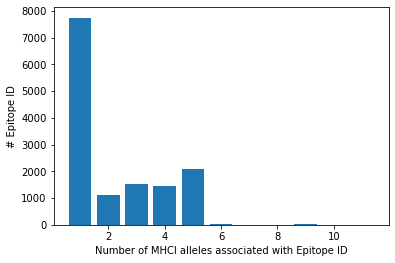

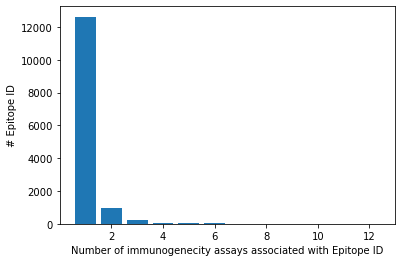

In [10]:
epitope_IDS = epitope_df["Epitope ID"]
unique_alleles = []
unique_assays = []
experiment_scores = dict()

for ID in epitope_IDS:
    if len(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]) == 0:
        continue

    number_of_assay_groups_for_id = len(set(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]["Assay Group"]))
    number_of_HLA_alleles = len(set(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]["Allele Name"]))
    unique_alleles.append(number_of_HLA_alleles)
    unique_assays.append(number_of_assay_groups_for_id)

    if number_of_assay_groups_for_id  == 0 :
        print(experiment_raw_df[experiment_raw_df["Epitope ID"] == ID])



    peptide = list(epitope_df[epitope_df["Epitope ID"] == ID]["Description"])[0]
    experiments_with_peptide = experiment_raw_df[experiment_raw_df["Epitope ID"] == ID]
    
    
    for i,experiment in experiments_with_peptide.iterrows():
        if experiment["Antigen Description"] == peptide:
            unique_identifier = peptide + "_" + experiment["Allele Name"]
            
            if unique_identifier not in experiment_scores.keys():
                experiment_scores[unique_identifier] = dict()
            
            assay = experiment["Assay Group"]
            tested_subjects = experiment["Number of Subjects Tested"]
            positive_subjects = experiment["Number of Subjects Responded"]
            N = tested_subjects
            m = positive_subjects
            a = 1 + m
            b = 1 + N - m
            score = betabinom.mean(1,a, b)
            
            if assay not in experiment_scores[unique_identifier].keys():
                experiment_scores[unique_identifier][assay] = [score]
            else:
                experiment_scores[unique_identifier][assay].append(score)


unique_alleles, counts= np.unique(unique_alleles,return_counts=True)
plt.bar(unique_alleles,counts)
plt.xlabel("Number of MHCI alleles associated with Epitope ID")
plt.ylabel("# Epitope ID")
plt.show()

unique_assays, counts= np.unique(unique_assays,return_counts=True)
plt.bar(unique_assays,counts)
plt.xlabel("Number of immunogenecity assays associated with Epitope ID")
plt.ylabel("# Epitope ID")
plt.show()

## Count of assays occurences

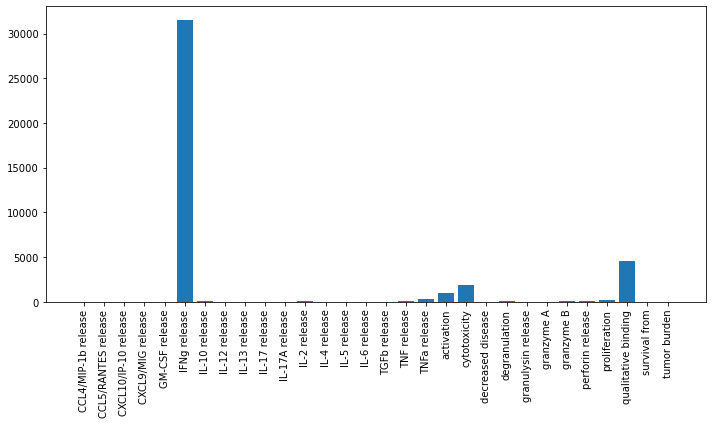

In [17]:
epitope_IDS = epitope_df["Epitope ID"]
experiments = experiment_raw_df[experiment_raw_df["Epitope ID"].isin(epitope_IDS)]["Assay Group"].to_numpy()
unique_experiments,counts = np.unique(experiments,return_counts=True)

experiment_counter = {x:y for x,y in zip(unique_experiments,counts)}

most_common_experiments = sorted(experiment_counter.keys(),key=lambda x: experiment_counter[x],reverse=True)
fig = plt.figure(figsize=(10,6))
plt.bar(np.arange(len(unique_experiments)),counts)
unique_experiments = [" ".join(x.split()[:2]) for x in unique_experiments]
plt.xticks(np.arange(len(unique_experiments)),unique_experiments,rotation=90)

plt.tight_layout()
plt.show()

## Correlation between immunogenecity scores

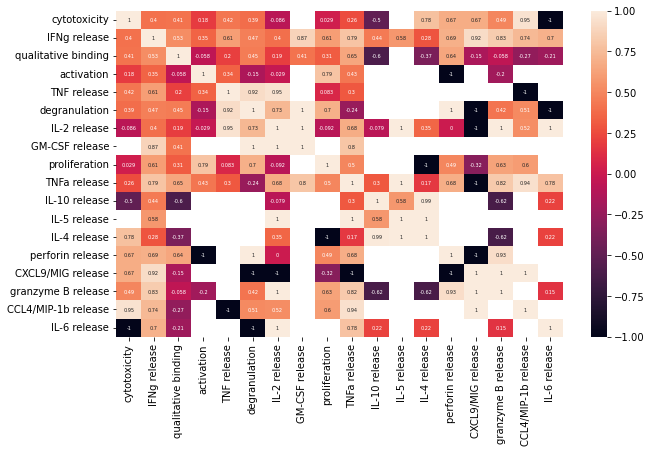

In [27]:
assay_correlation_dict = copy.deepcopy(experiment_scores)
for peptide_HLA in assay_correlation_dict.keys():
    for assay in assay_correlation_dict[peptide_HLA].keys():
        assay_correlation_dict[peptide_HLA][assay] = np.mean(assay_correlation_dict[peptide_HLA][assay])

assay_correlation_df = pd.DataFrame.from_dict(assay_correlation_dict).T
assay_correlation_df = assay_correlation_df.iloc[:-10,:-10]
fig = plt.figure(figsize=(10,6))
corr = assay_correlation_df.corr(method="spearman")
sns.heatmap(corr,annot=True,annot_kws={"fontsize":5})
plt.show()


## Standard deviation of immunogenecity scores

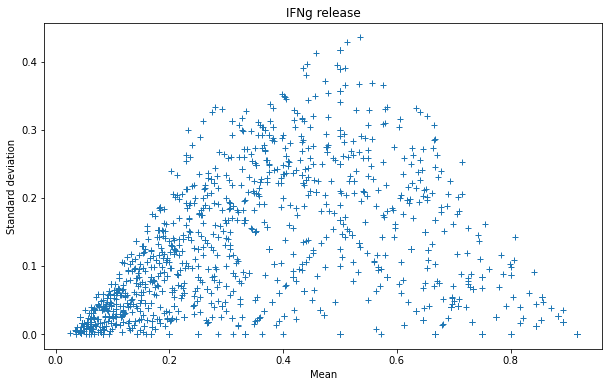

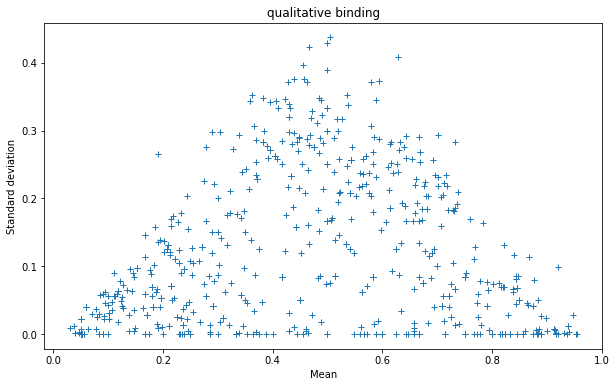

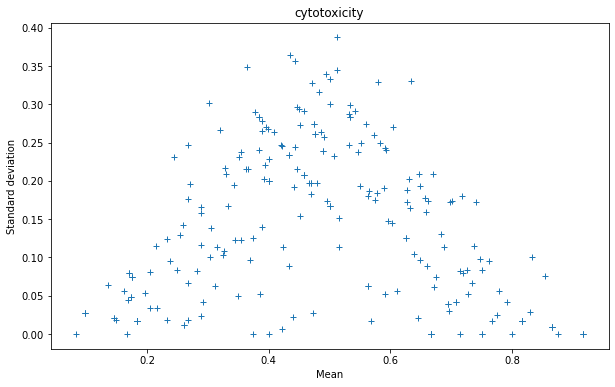

In [26]:
for assay in ç[:3]:
    means = []
    stds = []
    number_of_assays = []
    for peptide in experiment_scores.keys():
        try:
            if len(experiment_scores[peptide][assay]) > 1:
                number_of_assays.append(len(experiment_scores[peptide][assay]))
                mean, std = np.mean(experiment_scores[peptide][assay]), np.std(experiment_scores[peptide][assay])
                means.append(mean)
                stds.append(std)
        except KeyError:
            continue


    plt.figure(figsize=(10,6))
    plt.title(assay)
    plt.plot(means,stds,"+")
    plt.xlabel("Mean")
    plt.ylabel("Standard deviation")
    plt.show()

    # unique_assays, counts= np.unique(np.array(number_of_assays),return_counts=True)
    # plt.bar(unique_assays[:10],counts[:10])
    # plt.show()



## What types of HLA alleles is found in the dataset?

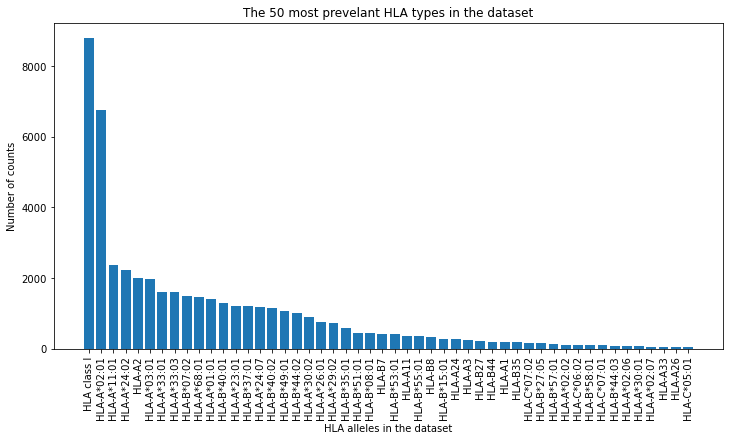

In [4]:
def show_HLA_dist(experiment_data):
    unique, counts = np.unique(experiment_data["Allele Name"],return_counts=True)
    count_dict = {allele:count for (allele,count) in zip(unique, counts)}
    unique = sorted(unique,key=lambda x: count_dict[x],reverse=True)
    counts = [count_dict[x] for x in unique]

    N = 50
    fig = plt.figure(figsize=(12,6))
    plt.bar(np.arange(N),counts[:N])
    plt.xticks(np.arange(N),unique[:N],rotation=90)
    plt.title("The 50 most prevelant HLA types in the dataset")
    plt.xlabel("HLA alleles in the dataset")
    plt.ylabel("Number of counts")
    plt.show()
show_HLA_dist(experiment_raw_df)


## What is the distrobution of wanted MHCI alleles?

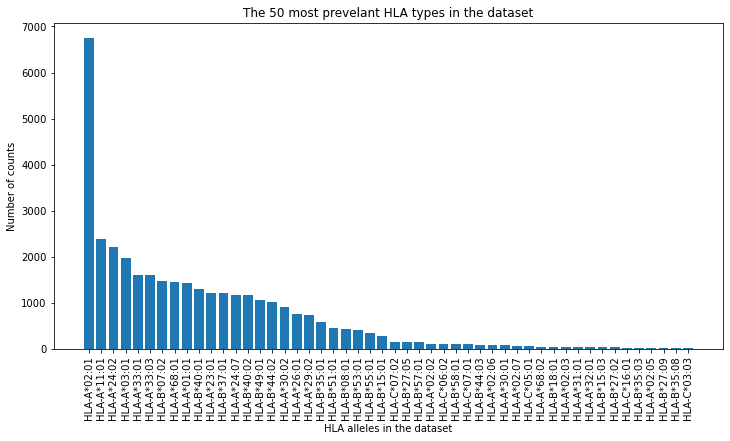

In [5]:
# Fitler based on a specific HLA alelle
alleles = ["*" in x for x in experiment_raw_df["Allele Name"]]
experiment_data = experiment_raw_df[alleles]
show_HLA_dist(experiment_data)


/var/folders/px/wpqhk62d559gjgm0ql254vq00000gn/T/ipykernel_49135/1940497282.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_data["epitope_length"] = experiment_data["Antigen Description"].apply(lambda x: len(x.strip()))


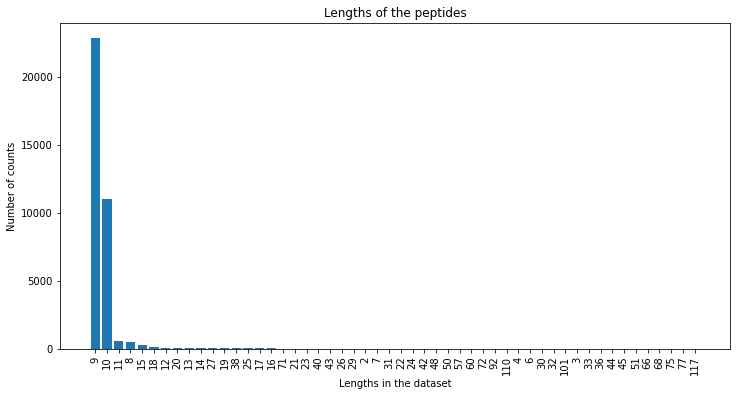

In [6]:
def show_peptide_lengths(experiment_data):
    ## Filter based on epitope length
    unique, counts = np.unique(experiment_data["epitope_length"],return_counts=True)
    count_dict = {allele:count for (allele,count) in zip(unique, counts)}
    unique = sorted(unique,key=lambda x: count_dict[x],reverse=True)
    counts = [count_dict[x] for x in unique]

    fig = plt.figure(figsize=(12,6))
    plt.bar(np.arange(len(counts)),counts)
    plt.xticks(np.arange(len(unique)),unique,rotation=90)
    plt.title("Lengths of the peptides")
    plt.xlabel("Lengths in the dataset")
    plt.ylabel("Number of counts")
    plt.show()


epitope_ids,counts = np.unique(experiment_data["Epitope ID"],return_counts=True)
experiment_data["epitope_length"] = experiment_data["Antigen Description"].apply(lambda x: len(x.strip()))
show_peptide_lengths(experiment_data)
filter_lengths = [9,10]
experiment_data = experiment_data[experiment_data.epitope_length.isin(filter_lengths)]



## Filter based on tested subjects

In [7]:
# experiment_data = experiment_data[experiment_data.epitope_length.isin(filter_lengths)]
# experiment_data = experiment_data[experiment_data["Number of Subjects Responded"] > 2]

## How many different MHCI alleles does each peptide bind and does it retain it's immunogenecity score?

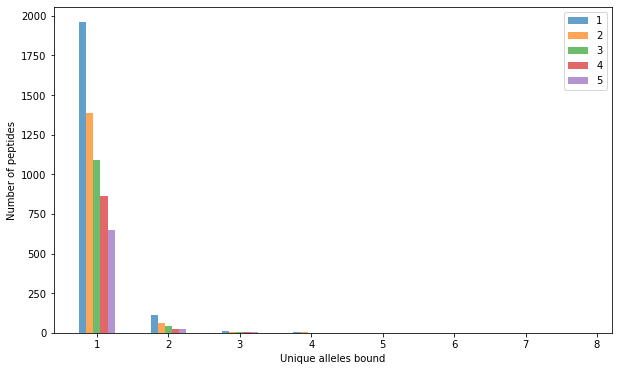

In [8]:
unique_peptides = set(experiment_data["Antigen Description"])
fig = plt.figure(figsize=(10,6))
for i in range(1,6):
    tmp_data = experiment_data[experiment_data["Number of Subjects Responded"] > i]
    unique_peptides = set(tmp_data["Antigen Description"])

    MHCI_allele_pr_peptide = dict()
    for peptide in unique_peptides:
        MHCI_allels = set(tmp_data[tmp_data["Antigen Description"]==peptide]["Allele Name"])
        MHCI_allele_pr_peptide[peptide] = MHCI_allels
    number_of_MCI_alleles = [len(MHCI_allele_pr_peptide[x]) for x in MHCI_allele_pr_peptide.keys()]
    unique,counts = np.unique(number_of_MCI_alleles,return_counts=True)

    plt.bar(unique + (-0.3 + i*0.1),counts,alpha=0.7,width=0.1,label=f"{i}")

plt.legend()
plt.xlabel("Unique alleles bound")
plt.ylabel("Number of peptides")
plt.show()

In [150]:
def calculate_identity(query,database):
    if len(query) == len(database):
        return np.sum([1 for i in range(len(query)) if query[i] == database[i]])/len(query)
    
    elif len(query) > len(database):
        max_score = 0
        diff_len = len(query) - len(database)
        for i in range(diff_len + 1):
            query_shortened = query[i:i+len(database)]
            score = np.sum([1 for i in range(len(query_shortened)) if query_shortened[i] == database[i]])/len(query_shortened)
            if score > max_score:
                max_score = score

        return max_score
    
    elif len(query) < len(database):
        max_score = 0
        diff_len = len(database) - len(query)
        for i in range(diff_len + 1):
            database_shortened = database[i:i+len(query)]
            score = np.sum([1 for i in range(len(query)) if query[i] == database_shortened[i]])/len(database_shortened)
            if score > max_score:
                max_score = score

        return max_score

pep1 = "RLNEVAKNLY"
pep2 = "RPKVEGLEY"
calculate_identity(pep2,pep1)

0.2222222222222222

In [151]:
deep_immuno = pd.read_csv("/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/deep_immuno_2.csv")
deep_immuno.head()

peptide         HLA immunogenicity  test  respond  potential
0   KEHVFFSEY  HLA-B*4402       Negative     4        0   0.347444
1   DEGATLYRF  HLA-B*4402       Negative     4        0   0.346545
2   TLAARIKFL  HLA-A*0201       Negative     4        0   0.346239
3  KETLNEYKQL  HLA-B*4402       Negative     4        0   0.345162
4   STTDAEACY  HLA-A*0101       Negative     4        0   0.343674

In [152]:
print(len(set(deep_immuno["peptide"])))
print(len(deep_immuno["peptide"]))

8383
8971


Creating identity matrix
Creating clustermap


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 720x432 with 0 Axes>

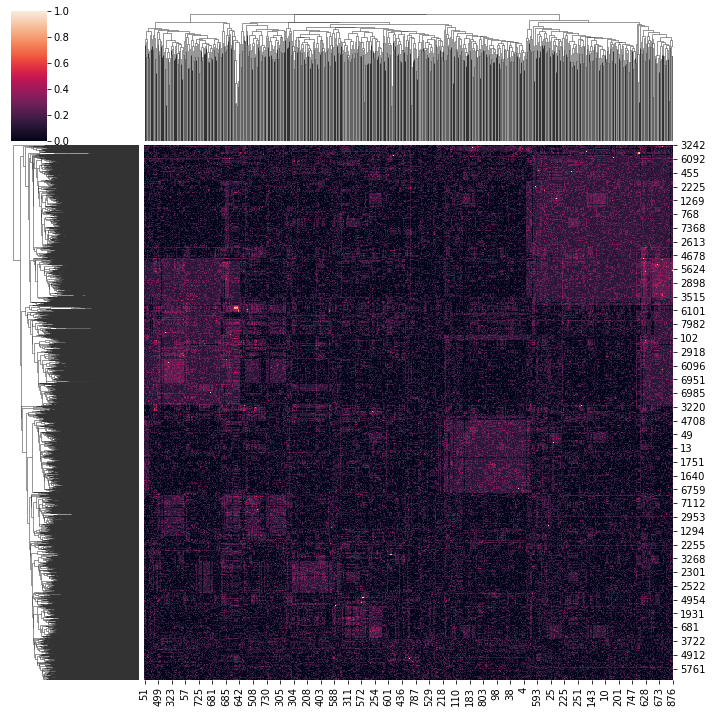

Nested same MHCI: 108
Nested different MHCI: 38
Same peptide different MHCI: 84


SystemExit: 1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [153]:
# peptides = np.array(experiment_data[experiment_data["Number of Subjects Responded"] > 4]["Antigen Description"])
peptides = np.array(deep_immuno["peptide"])
HLAs = np.array(deep_immuno["HLA"])
identical_peptides = dict()

kf = KFold(n_splits=10,shuffle=True)
kf.get_n_splits(peptides)
for train_index, test_index in kf.split(peptides):
    X_train, X_test = peptides[train_index], peptides[test_index]
    hla_train, hla_test = HLAs[train_index], HLAs[test_index]
    
    # identity_matrix = [[0 for _ in range(len(X_test))] for _ in range(len(X_train))]
    print("Creating identity matrix")
    identity_matrix = np.array([[calculate_identity(pep1,pep2) for pep2 in X_test] for pep1 in X_train])
    
    # sns.heatmap(identity_matrix)
    fig = plt.figure(figsize=(10,6))
    print("Creating clustermap")
    sns.clustermap(identity_matrix)
    plt.show()
    # print(np.sum(identity_matrix == 1))
    train_loc, val_loc = np.where(identity_matrix==1)
    nested = []
    val =[]


    for val_i, train_i in zip(val_loc,train_loc):
        if val_i not in identical_peptides.keys():
            identical_peptides[val_i] = {"Nested different MHCI":0,
                                        "Nested same MHCI":0,
                                        "Same peptide different MHCI":0}
        
        if len(X_test[val_i]) != len(X_train[train_i]) and hla_test[val_i] != hla_train[train_i]:
            identical_peptides[val_i]["Nested different MHCI"] += 1
        elif len(X_test[val_i]) != len(X_train[train_i]) and hla_test[val_i] == hla_train[train_i]:
            identical_peptides[val_i]["Nested same MHCI"] += 1
            
        elif len(X_test[val_i]) == len(X_train[train_i]) and hla_test[val_i] != hla_train[train_i]:
            identical_peptides[val_i]["Same peptide different MHCI"] += 1
            
        else:
            print(X_test[val_i])
            print(X_train[train_i])
            print(hla_test[val_i])
            print(hla_train[train_i])
            print()


    identical_peptides_df = pd.DataFrame.from_dict(identical_peptides).T
    print("Nested same MHCI:",len(identical_peptides_df[identical_peptides_df["Nested same MHCI"]>0]))
    print("Nested different MHCI:",len(identical_peptides_df[identical_peptides_df["Nested different MHCI"]>0]))
    print("Same peptide different MHCI:",len(identical_peptides_df[identical_peptides_df["Same peptide different MHCI"]>0]))

    pd.DataFrame.from_dict(identical_peptides).T
    sys.exit(1)


In [139]:

print(identical_peptides_df)

     Nested different MHCI  Nested same MHCI  Same peptide different MHCI
135                      0                 1                            0
13                       0                 1                            0
38                       1                 0                            0
260                      0                 1                            0
6                        0                 1                            0
..                     ...               ...                          ...
874                      0                 1                            0
339                      1                 0                            0
818                      1                 0                            0
808                      0                 1                            0
676                      1                 0                            0

[134 rows x 3 columns]


98
43
0


In [110]:
np.max(np.where(identity_matrix==1)[1])

# identity_matrix.shape

893

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 864x576 with 0 Axes>

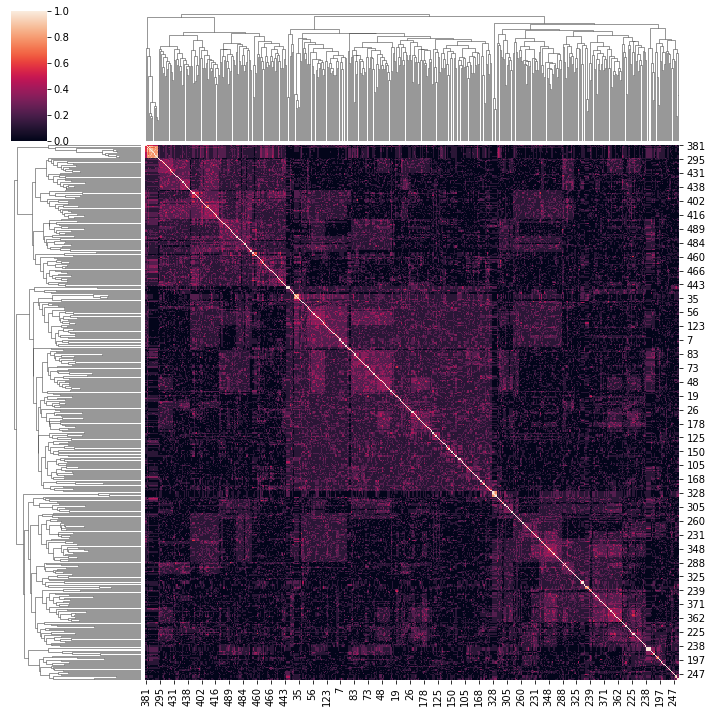

In [82]:
peptides = np.array(deep_immuno["peptide"])[:500]
identity_matrix = np.array([[calculate_identity(pep1,pep2) for pep2 in peptides] for pep1 in peptides])
plt.figure(figsize=(12,8))
sns.clustermap(identity_matrix)
plt.show()



In [83]:
(np.sum(identity_matrix == 1) - np.sum(np.diag(identity_matrix)))/2

45.0

In [84]:
x_loc,y_loc = np.where(identity_matrix == 1 - np.identity(len(identity_matrix)))

for x,y in zip(x_loc,y_loc):
    print(deep_immuno.iloc[x,:])
    print(deep_immuno.iloc[y,:])
    print(peptides[x])
    print(peptides[y])
    print(x,y)
    sys.exit(1)



Unnamed: 0                    31
peptide                ADVEFCLSL
HLA_allele           HLA-A*02:01
immunogenicity          0.058824
tested_subjects             15.0
positive_subjects            0.0
Name: 6, dtype: object
Unnamed: 0                    32
peptide                ADVEFCLSL
HLA_allele           HLA-B*44:03
immunogenicity               0.5
tested_subjects              6.0
positive_subjects            3.0
Name: 7, dtype: object
ADVEFCLSL
ADVEFCLSL
6 7


SystemExit: 1

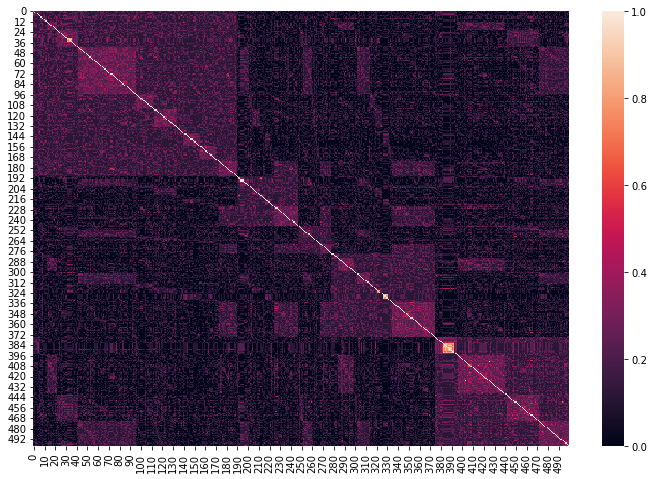

In [85]:
plt.figure(figsize=(12,8))
sns.heatmap(identity_matrix)
plt.show()

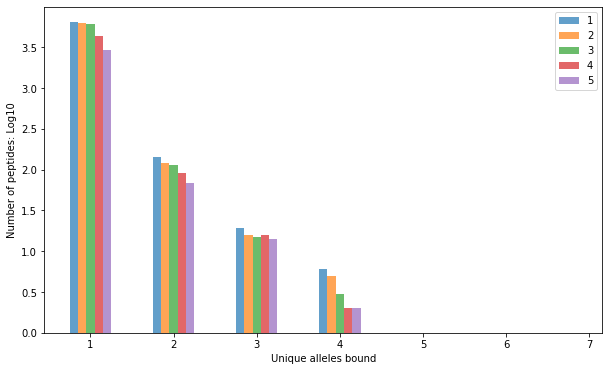

In [52]:
fig = plt.figure(figsize=(10,6))
for i in range(1,6):
    tmp_data = deep_immuno[deep_immuno["test"] > i]
    unique_peptides = set(tmp_data["peptide"])

    MHCI_allele_pr_peptide = dict()
    for peptide in unique_peptides:
        MHCI_allels = set(tmp_data[tmp_data["peptide"]==peptide]["HLA"])
        MHCI_allele_pr_peptide[peptide] = MHCI_allels
    number_of_MCI_alleles = [len(MHCI_allele_pr_peptide[x]) for x in MHCI_allele_pr_peptide.keys()]
    unique,counts = np.unique(number_of_MCI_alleles,return_counts=True)

    plt.bar(unique + (-0.3 + i*0.1),np.log10(counts),alpha=0.7,width=0.1,label=f"{i}")

plt.legend()
plt.xlabel("Unique alleles bound")
plt.ylabel("Number of peptides: Log10")
plt.show()

In [55]:
deep_immuno.sample(frac=1, replace=False).set_index(pd.Index(np.arange(deep_immuno.shape[0])))

peptide         HLA immunogenicity  test  respond  potential
0     TIDIDETISY  HLA-A*0101       Negative     4        0   0.305404
1     GTSGSPIINK  HLA-A*1101       Positive     0        0   0.970863
2     GLLGCIITSL  HLA-A*0201       Positive    22        1   0.583555
3      DLCGSVFLV  HLA-A*0201       Negative    16        0   0.143353
4      FLDPASIAA  HLA-A*0201       Positive    79       52   0.740646
...          ...         ...            ...   ...      ...        ...
8966  HPSDGKCNLY  HLA-B*3501       Negative     8        0   0.224954
8967  SLNFLGGAPK  HLA-A*1101       Negative    33        0   0.075677
8968   LLFGYPVYV  HLA-A*0205       Positive     0        0   0.965971
8969  KMIAKSEQEI  HLA-A*0201       Negative    12        0   0.164612
8970   NERKDSIKF  HLA-B*4402       Negative     4        0   0.299129

[8971 rows x 6 columns]

0.75

In [16]:
duplication = set()
outfile = open("lort.txt","w+")
i = 0 
for index,row in experiment_data.iterrows():
    if row["Epitope ID"] not in duplication:
        print(">{}".format(row["Epitope ID"]),file=outfile)
        print(row["Antigen Description"],file=outfile)
    duplication.add(row["Epitope ID"])
    i += 1
outfile.close()


## Calculate immunogenecity scores for the peptides

Collecting the different experiments for each epitope

In [17]:
immunogenecity_of_epitope_id = dict()
N,M = experiment_data.shape
for i in range(N):
    epitope_id = experiment_data.iloc[i]["Epitope ID"]
    tested_subjects = experiment_data.iloc[i]["Number of Subjects Tested"]
    positive_subjects = experiment_data.iloc[i]["Number of Subjects Responded"]
    if str(positive_subjects) == "nan":
        print(experiment_data.iloc[i])

    if epitope_id not in immunogenecity_of_epitope_id.keys():
        immunogenecity_of_epitope_id[epitope_id] = {"tested_subjects":[tested_subjects],"positive_subjects":[positive_subjects],"percentage_positive":[positive_subjects/tested_subjects]}
    else:
        immunogenecity_of_epitope_id[epitope_id]["tested_subjects"].append(tested_subjects)
        immunogenecity_of_epitope_id[epitope_id]["positive_subjects"].append(positive_subjects)
        immunogenecity_of_epitope_id[epitope_id]["percentage_positive"].append(positive_subjects/tested_subjects)


Calculating a weighted average 

In [18]:
# Calculating weighted average
for epitope_id in immunogenecity_of_epitope_id.keys():
    immunogenecity_of_epitope_id[epitope_id]["wieghted average"] = np.average(immunogenecity_of_epitope_id[epitope_id]["percentage_positive"],weights=immunogenecity_of_epitope_id[epitope_id]["tested_subjects"])

# Colelcting immunogenecity scores in list
N,M = experiment_data.shape
immunogenecity_scores = []
for i in range(N):
    try:
        immunogenecity_scores.append(immunogenecity_of_epitope_id[experiment_data.loc[i]["Epitope ID"]]["wieghted average"])
    except KeyError:
        immunogenecity_scores.append(float("nan"))

# Add to dataframe
experiment_data["immunogeencity"] = immunogenecity_scores
experiment_data = experiment_data.dropna()

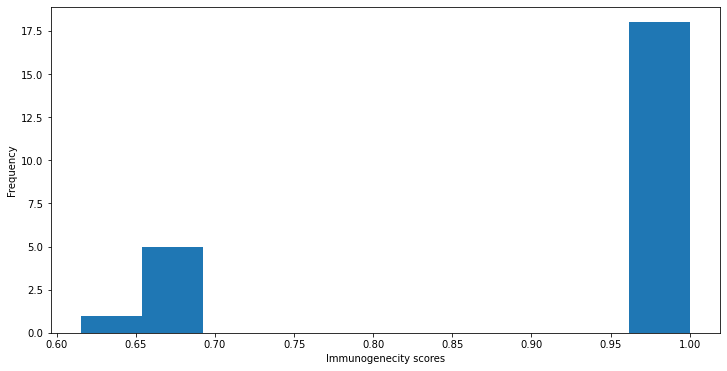

In [19]:
epitope_raw_df
fig = plt.figure(figsize=(12,6))
experiment_data["immunogeencity"].plot.hist()
plt.xlabel("Immunogenecity scores")
plt.show()

## Encoding peptides

In [37]:
def onehot_encode_peptide(peptide):
    aminoacids = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    encoded_peptide = pd.Series(list(peptide))
    encoded_peptide = encoded_peptide.astype(pd.CategoricalDtype(categories=aminoacids))
    encoded_peptide = pd.get_dummies(encoded_peptide)
    return encoded_peptide.to_numpy()

def categorical_encode_peptide(peptide):
    aminoacids = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    encoded_peptide = np.array([aminoacids.index(x)+1 for x in list(peptide)])
    return encoded_peptide


def read_aa_feature_matrix(columns):
    df = pd.read_csv("/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/features_AIMS.txt",index_col=0)
    df = df.loc[columns]
    return df


def encode_with_aa_features(peptide,feature_matrix):
    encoded_peptide = []
    for aa in peptide:
        encoded_peptide.append(feature_matrix[aa].to_list())
    encoded_peptide = np.array([np.array(x) for x in encoded_peptide])
    return encoded_peptide  




def blossom62_encode_peptide(peptide):
    blossom62_matrix = pd.read_csv("../blossom62",sep="\t")
    print(blossom62_matrix.columns)
    sys.exit(1)

def read_aa_index():
    with open("/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/aaindex1","r") as f:
        for line in f:
            print(line)
            sys.exit(1)

feature_columns = ["charge_key","hydrophobicity","bulk","flex"]
feature_matrix = read_aa_feature_matrix(feature_columns)


N,M = experiment_data.shape
X = []
onehot = []
categorical = []
aims_features = []
for i in range(N):
    peptide = experiment_data.iloc[i]["Antigen Description"]
    # One-hot encoding
    one_hot_encoded_peptide = onehot_encode_peptide(peptide)
    onehot.append(one_hot_encoded_peptide.reshape(-1,))
    # Categorical encoding
    categorical_encoded_peptide = categorical_encode_peptide(peptide)
    categorical.append(categorical_encoded_peptide.reshape(-1,))
    # AIMS encoding
    aims_encoded = encode_with_aa_features(peptide,feature_matrix).astype(np.float)
    aims_features.append(aims_encoded)

experiment_data["categorical"] = categorical
experiment_data["onehot"] = onehot
experiment_data["aims"] = aims_features

/var/folders/px/wpqhk62d559gjgm0ql254vq00000gn/T/ipykernel_2502/524700908.py:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aims_encoded = encode_with_aa_features(peptide,feature_matrix).astype(np.float)
/var/folders/px/wpqhk62d559gjgm0ql254vq00000gn/T/ipykernel_2502/524700908.py:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  aims_e

In [39]:
experiment_data

Epitope ID    Cell Type  Allele Name Antigen Description  \
452         17119         PBMC  HLA-A*02:01           FMYSDFHFI   
458         59673         PBMC  HLA-A*02:01           SMIEAESSV   
459         54584         PBMC  HLA-A*02:01           RLIDFLKDV   
488         33447         PBMC  HLA-A*11:01           KSMREEYRK   
596         20354  T cell CD8+  HLA-A*02:01           GILGFVFTL   
...           ...          ...          ...                 ...   
77026     1323998  T cell CD8+  HLA-A*30:01           RNRFLYIIK   
77027       54507  T cell CD8+  HLA-A*02:01           RLDKVEAEV   
77079       16762  T cell CD8+  HLA-A*02:07           FLLVTLAIL   
77091      989936  T cell CD8+  HLA-A*02:01           KLQCVDLHV   
77092      989936  T cell CD8+  HLA-A*02:01           KLQCVDLHV   

      Qualitative Measure          Assay Group  Number of Subjects Tested  \
452              Positive         cytotoxicity                        6.0   
458              Negative         cytotoxicity                        6.0   
459              Negative         cytotoxicity                        6.0   
488              Positive         cytotoxicity                        6.0   
596              Positive         IFNg release                       29.0   
...                   ...                  ...                        ...   
77026            Positive         IFNg release                        3.0   
77027            Positive         IFNg release                        3.0   
77079            Positive         IFNg release                        3.0   
77091       Positive-High  qualitative binding                       15.0   
77092            Positive  qualitative binding                       11.0   

       Number of Subjects Responded  epitope_length  immunogeencity  \
452                             2.0               9        0.363636   
458                             0.0               9        1.000000   
459                             0.0               9        1.000000   
488                             1.0               9        0.750000   
596                            28.0               9        0.750000   
...                             ...             ...             ...   
77026                           2.0               9        0.000000   
77027                           1.0               9        0.000000   
77079                           1.0               9        0.000000   
77091                          15.0               9        0.000000   
77092                          11.0               9        0.000000   

                               categorical  \
452     [14, 13, 19, 16, 4, 14, 9, 14, 10]   
458      [16, 13, 10, 7, 1, 7, 16, 16, 20]   
459      [2, 11, 10, 4, 14, 11, 12, 4, 20]   
488       [12, 16, 13, 2, 7, 7, 19, 2, 12]   
596     [8, 10, 11, 8, 14, 20, 14, 17, 11]   
...                                    ...   
77026    [2, 3, 2, 14, 11, 19, 10, 10, 12]   
77027      [2, 11, 4, 12, 20, 7, 1, 7, 20]   
77079  [14, 11, 11, 20, 17, 11, 1, 10, 11]   
77091     [12, 11, 6, 5, 20, 4, 11, 9, 20]   
77092     [12, 11, 6, 5, 20, 4, 11, 9, 20]   

                                                  onehot  \
452    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
458    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
459    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
488    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   
596    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                  ...   
77026  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
77027  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
77079  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
77091  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   
77092  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...   

                                                    aims  
452    [[0.0, -0.58, 0.2585499357889891, 0.915], [0.0...  
458    [[0.0, 0.33, 0.1621607053

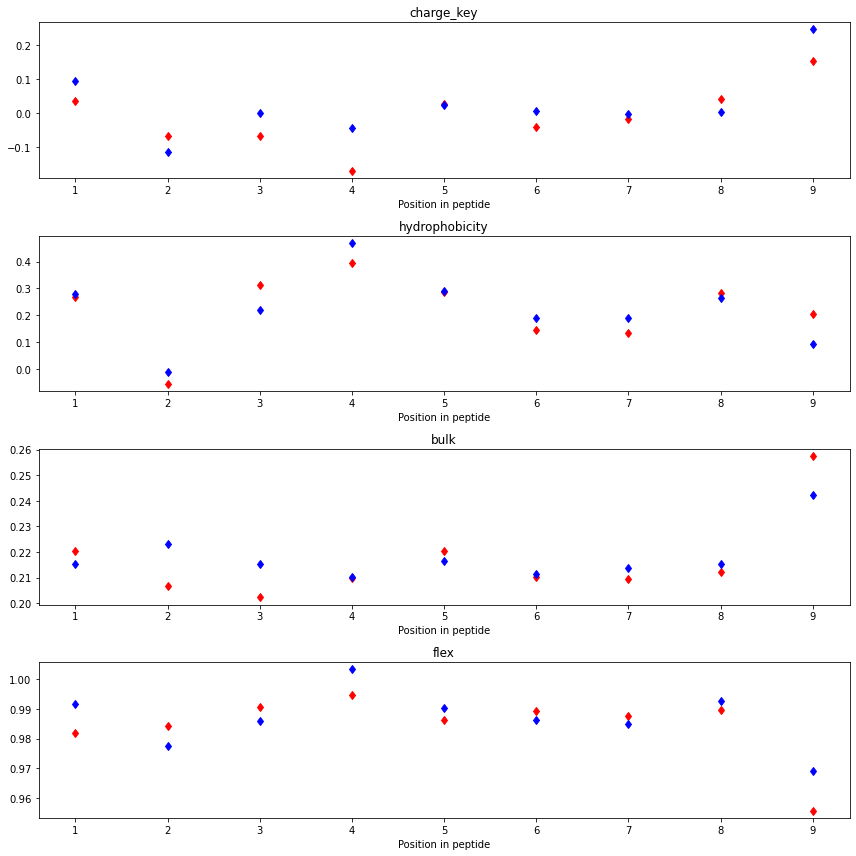

In [40]:
def calculate_averages_and_std_feature(df):
    N,M = df.shape
    pos_specific_data = [[[] for _ in feature_columns] for _ in range(9)]
    for i in range(N):
        for aa_pos,feat_scores in enumerate(df.iloc[i]["aims"]):
            for feat_index,feat_score in enumerate(feat_scores):
                pos_specific_data[aa_pos][feat_index].append(feat_score)
    averages_and_std = [[0 for _ in feature_columns] for _ in range(9)]

    for pos,pos_data in enumerate(pos_specific_data):
        for feat,feat_data in enumerate(pos_data):
            averages_and_std[pos][feat] = (np.mean(feat_data),np.std(feat_data))
    return averages_and_std


non_immunogenic_X = experiment_data[experiment_data['immunogeencity'] <= 0]
immunogenic_X = experiment_data[experiment_data['immunogeencity'] > 0.5]

average_features_non_immunogenic = calculate_averages_and_std_feature(non_immunogenic_X)
average_features_immunogenic = calculate_averages_and_std_feature(immunogenic_X)

fig1, axs1 = plt.subplots(nrows=4,ncols=1,figsize=(12,12))
plt.setp(axs1, xticks=np.arange(9), xticklabels=np.arange(9)+1)
for feature in range(len(average_features_immunogenic[0])):
    # fig = plt.figure()
    for pos in range(len(average_features_immunogenic)):
        axs1[feature].plot(pos,average_features_immunogenic[pos][feature][0],marker="d",color="red")
        axs1[feature].plot(pos,average_features_non_immunogenic[pos][feature][0],marker="d",color="blue")
        ## Plotting errorbars of the features
        # axs1[feature].errorbar(pos, average_features_immunogenic[pos][feature][0], yerr=average_features_immunogenic[pos][feature][1],color="black")
        # axs1[feature].errorbar(pos, average_features_non_immunogenic[pos][feature][0], yerr=average_features_non_immunogenic[pos][feature][1],color="grey")
    axs1[feature].set_xlabel("Position in peptide")
    axs1[feature].set_title(feature_columns[feature])
fig1.tight_layout()
plt.show()
    

In [41]:
non_immunogenic_X = epitope_raw_df[epitope_raw_df['immunogeencity'] <= 0]["categorical"].to_numpy()
immunogenic_X = epitope_raw_df[epitope_raw_df['immunogeencity'] > 0]["categorical"].to_numpy()

non_immunogenic_X_categorical = np.vstack(non_immunogenic_X).astype(np.float)
immunogenic_X_categorical = np.vstack(immunogenic_X).astype(np.float)
total_categorical = np.concatenate((non_immunogenic_X_categorical, immunogenic_X_categorical), axis=0)

print(non_immunogenic_X_categorical.shape)
print(immunogenic_X_categorical.shape)
print(total_categorical.shape)

KeyError: 'immunogeencity'

Text(0, 0.5, 'AA Position')

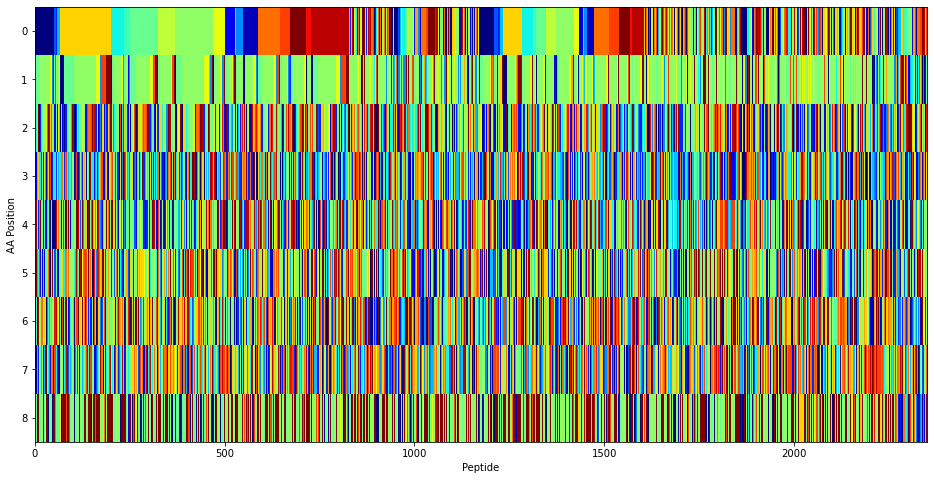

In [141]:
fig, ax = plt.subplots(1, 1,squeeze=False,figsize=(16,8))
matrix=ax[0,0].imshow(np.transpose(total_categorical[:,:]), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_xlabel('Peptide')
ax[0,0].set_ylabel('AA Position')

In [142]:
X_onehot = epitope_raw_df["onehot"].to_numpy()
X_onehot = np.vstack(X_onehot).astype(np.float)
N,M = X_onehot.shape
Y = epitope_raw_df["immunogeencity"].to_numpy().astype(float)

Text(0, 0.5, 'PC2 0.28')

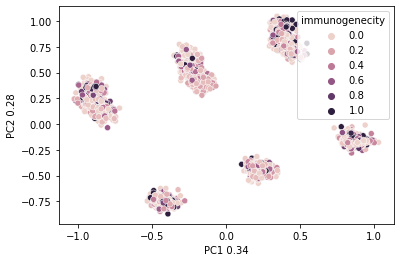

In [143]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_onehot)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf["immunogenecity"] = Y
# principalDf.loc[principalDf['immunogenecity'] <= 0.1, 'immunogenecity'] = 0
# principalDf.loc[principalDf['immunogenecity'] > 0.1, 'immunogenecity'] = 1
pc1_var, pc2_var = pca.explained_variance_
sns.scatterplot(data=principalDf, x="principal component 1", y="principal component 2",hue="immunogenecity")
plt.xlabel(f"PC1 {round(pc1_var,2)}")
plt.ylabel(f"PC2 {round(pc2_var,2)}")

# Applying different clustering strategies

In [145]:
from sklearn.cluster import Birch
from matplotlib import pyplot

Text(0, 0.5, 'PC2 0.28')

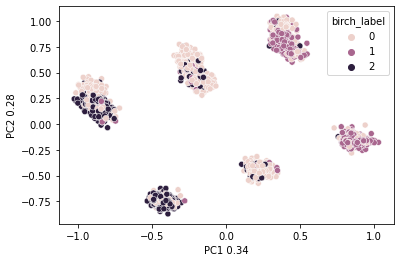

In [147]:
model = Birch(threshold=0.01, n_clusters=3)
model.fit(X_onehot)
birch_predictions = model.predict(X_onehot)
principalDf["birch_label"] = birch_predictions
sns.scatterplot(data=principalDf, x="principal component 1", y="principal component 2",hue="birch_label")
plt.xlabel(f"PC1 {round(pc1_var,2)}")
plt.ylabel(f"PC2 {round(pc2_var,2)}")

2.1


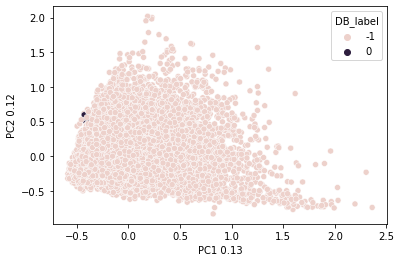

2.6


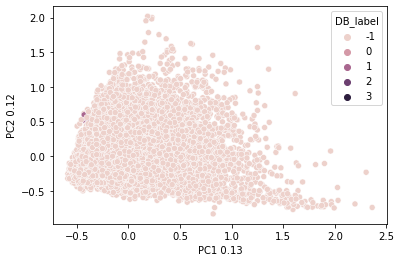

3.1


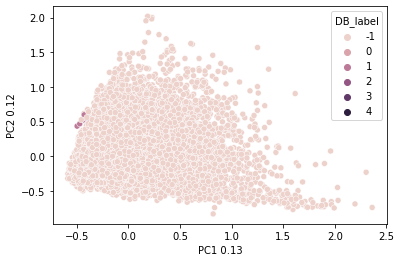

3.6


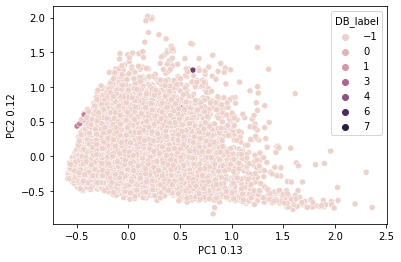

In [93]:
from sklearn.cluster import DBSCAN
for i in range(1,20,5):
    eps = 2 + 0.1*i
    print(eps)
    model_2 = DBSCAN(eps=eps, min_samples=10)
    DB_scan_predictions = model_2.fit_predict(X_r)
    finalDf["DB_label"] = DB_scan_predictions
    sns.scatterplot(data=finalDf, x="principal component 1", y="principal component 2",hue="DB_label")
    plt.xlabel(f"PC1 {round(pc1_var,2)}")
    plt.ylabel(f"PC2 {round(pc2_var,2)}")
    plt.show()

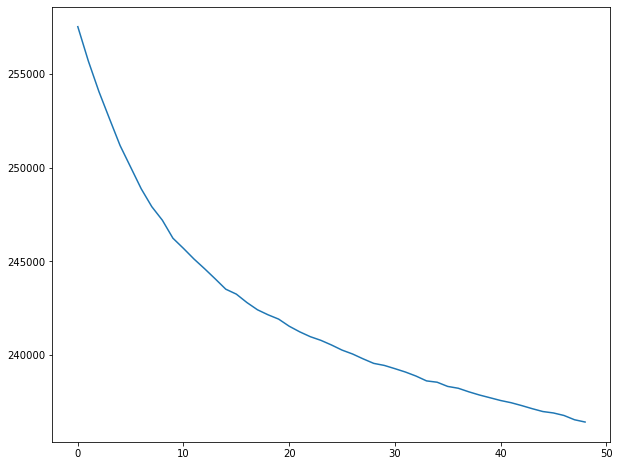

In [100]:
from sklearn.cluster import KMeans
intertia = []
for i in range(1,50):
    # define the model
    model_3 = KMeans(n_clusters=i)
    # fit the model_3
    model_3.fit(X_r)
    # assign a cluster to each example
    predictions = model_3.predict(X_r)
    # retrieve unique clusters
    intertia.append(model_3.inertia_)

fig = plt.figure(figsize=(10,8))
plt.plot(np.arange(len(intertia)),intertia)
plt.show()